# 3. Train model (Pytorch. Pretrained)

In [1]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
from pathlib import Path
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
from torchvision import transforms
import torch
import random
import numpy as np
import yaml
import torchvision.models as models

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    f1_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    accuracy_score,
    matthews_corrcoef,
)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt

## Define constants

In [2]:
ROOT = Path(os.path.abspath('')).resolve().parents[0]
FIGURES_PATH = os.path.join(ROOT, 'reports', 'figures')
DATA = os.path.join(ROOT, "data")
PROCESSED_DATA = os.path.join(DATA, "processed") 
INTERIM_DATA = os.path.join(DATA, "interim")
RAW_DATA = os.path.join(DATA, "raw")
FIGURES_PATH = os.path.join(ROOT, 'reports', 'figures')
GARBAGE_CLASSIFICATION_PATH  = os.path.join(RAW_DATA, "garbage_classification")

## Set random data

In [3]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
if torch.backends.mps.is_available():
    torch.mps.manual_seed(seed)

## Load data

### Classes

In [4]:
with open(os.path.join(INTERIM_DATA, "classes.yaml"), "r") as f:
    classes = yaml.safe_load(f)

classes

{1: 'glass', 2: 'paper', 3: 'cardboard', 4: 'plastic', 5: 'metal', 6: 'trash'}

### Datasets

In [5]:
df_train = pd.read_parquet(os.path.join(INTERIM_DATA, "df_train.parquet.gzip"))
df_val = pd.read_parquet(os.path.join(INTERIM_DATA, "df_val.parquet.gzip"))
df_test = pd.read_parquet(os.path.join(INTERIM_DATA, "df_test.parquet.gzip"))

## Transformations

For first iteration, let us not apply any transformations

In [6]:
input_size = 200

# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

val_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

## Dataset class

In [7]:
class GarbageClassificationDataset(Dataset):

    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        item = self.df.iloc[idx]
        img = Image.open(item['image_path']).convert('RGB')
        label = torch.tensor(int(item['class_idx']), dtype=torch.long)

        if self.transform:
            img = self.transform(img)

        return img, label

## Loaders

In [8]:
dataset_train = GarbageClassificationDataset(df=df_train, transform=train_transforms)
dataset_val = GarbageClassificationDataset(df=df_val, transform=val_transforms)
dataset_test = GarbageClassificationDataset(df=df_test, transform=val_transforms)

train_loader = DataLoader(dataset_train, batch_size=32)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

## Model

* For this model, let us use [`ResNet-50`](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html) pre-trained model

In [9]:
class GarbageClassificationPretrained(nn.Module):
    def __init__(self, num_classes: int = 6):
        super().__init__()
        self.network = models.resnet50(pretrained=True)
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, xb):
        return self.network(xb)

def get_device() -> torch.device:
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    return device

In [10]:
device = get_device()
model = GarbageClassificationPretrained()
model.to(device)

/Users/vadim.sokoltsov/learning/bin-it-right/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vadim.sokoltsov/learning/bin-it-right/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


GarbageClassificationPretrained(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample)

## Criterion and optimizer

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4,
)

## Train and evaluate model

In order to make it reusable, move the logic of model's training and evaluation to separate function:

In [12]:
def train_eval_model(
    model: nn.Module,
    num_epochs: int,
    best_model_path: str,
    optimizer,
    criterion,
) -> pd.DataFrame:
    rows = []
    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for _, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_acc": val_acc,
            }
            torch.save(best_model_state, best_model_path)
            print(f"  >> New best model! Val Acc = {val_acc:.4f}")

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}')

        rows.append((epoch, train_loss, train_acc, val_loss, val_acc))
        
    return pd.DataFrame(rows, columns=['epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc'])

In [13]:
best_model_pretrain_path = os.path.join(PROCESSED_DATA, "best_model_pretrained.pt")
df_train_val = train_eval_model(
    model=model,
    num_epochs=60,
    best_model_path=best_model_pretrain_path,
    optimizer=optimizer,
    criterion=criterion
)

  >> New best model! Val Acc = 0.4085
Epoch 1/60
  Train Loss: 1.1669, Train Acc: 0.5730
  Validation Loss: 1.8989, Validation Acc: 0.4085
  >> New best model! Val Acc = 0.5945
Epoch 2/60
  Train Loss: 0.8629, Train Acc: 0.6799
  Validation Loss: 1.2077, Validation Acc: 0.5945
  >> New best model! Val Acc = 0.6189
Epoch 3/60
  Train Loss: 0.6455, Train Acc: 0.7715
  Validation Loss: 1.2232, Validation Acc: 0.6189
  >> New best model! Val Acc = 0.7073
Epoch 4/60
  Train Loss: 0.5587, Train Acc: 0.8032
  Validation Loss: 0.8544, Validation Acc: 0.7073
  >> New best model! Val Acc = 0.7652
Epoch 5/60
  Train Loss: 0.4622, Train Acc: 0.8388
  Validation Loss: 0.7741, Validation Acc: 0.7652
Epoch 6/60
  Train Loss: 0.3757, Train Acc: 0.8676
  Validation Loss: 0.7902, Validation Acc: 0.7530
  >> New best model! Val Acc = 0.7957
Epoch 7/60
  Train Loss: 0.2748, Train Acc: 0.9106
  Validation Loss: 0.6103, Validation Acc: 0.7957
Epoch 8/60
  Train Loss: 0.3527, Train Acc: 0.8812
  Validation L

In [14]:
df_train_val.head(10)

,epoch,train_loss,train_acc,val_loss,val_acc
0,0,1.166911,0.572964,1.898921,0.408537
1,1,0.862858,0.679864,1.207652,0.594512
2,2,0.645530,0.771493,1.223152,0.618902
3,3,0.558728,0.803167,0.854447,0.707317
4,4,0.462190,0.838801,0.774082,0.765244
5,5,0.375693,0.867647,0.790246,0.753049
6,6,0.274774,0.910633,0.610325,0.795732
7,7,0.352683,0.881222,0.872230,0.731707
8,8,0.271423,0.907240,0.798301,0.762195
9,9,0.186480,0.932127,1.583265,0.643293


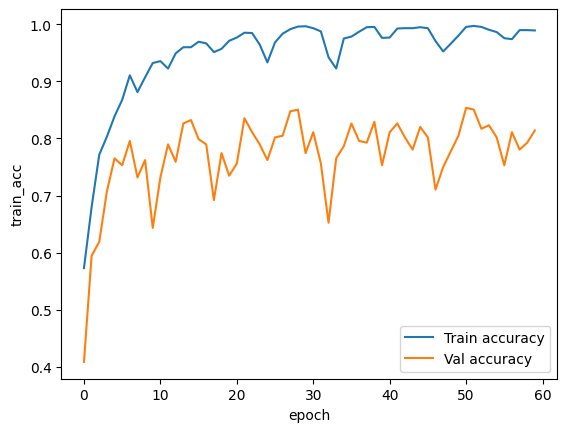

In [15]:
sns.lineplot(data=df_train_val, x='epoch', y='train_acc', label='Train accuracy')
sns.lineplot(data=df_train_val, x='epoch', y='val_acc', label='Val accuracy')
plt.savefig(
    os.path.join(FIGURES_PATH, "pytorch_pretrained_accuracy_default.png")
)
plt.show()

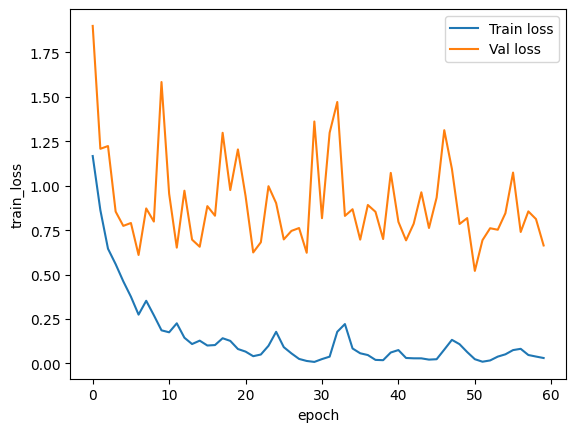

In [16]:
sns.lineplot(data=df_train_val, x='epoch', y='train_loss', label='Train loss')
sns.lineplot(data=df_train_val, x='epoch', y='val_loss', label='Val loss')
plt.savefig(
    os.path.join(FIGURES_PATH, "pytorch_pretrained_loss_default.png")
)
plt.show()

## Test model

In [17]:
from typing import Dict, List

def test_model(model: nn.Module) -> Dict[str, List[float]]:
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    return {
        'labels': all_labels,
        'preds': all_preds
    }

In [18]:
model = GarbageClassificationPretrained(num_classes=6)
checkpoint = torch.load(
    best_model_pretrain_path,
    map_location=device
)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()

test_data = test_model(model=model)

/Users/vadim.sokoltsov/learning/bin-it-right/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vadim.sokoltsov/learning/bin-it-right/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
y_true = test_data["labels"]
y_pred = test_data["preds"]

metrics = {
    "accuracy": accuracy_score(y_true, y_pred),
    "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
    "macro_f1": f1_score(y_true, y_pred, average="macro"),
    "weighted_f1": f1_score(y_true, y_pred, average="weighted"),
    "micro_f1": f1_score(y_true, y_pred, average="micro"),
    "macro_precision": precision_score(y_true, y_pred, average="macro", zero_division=0),
    "macro_recall": recall_score(y_true, y_pred, average="macro", zero_division=0),
    "mcc": matthews_corrcoef(y_true, y_pred),
}

for k, v in metrics.items():
    print(f"{k:>18}: {v:.4f}")

          accuracy: 0.8492
 balanced_accuracy: 0.8213
          macro_f1: 0.8299
       weighted_f1: 0.8475
          micro_f1: 0.8492
   macro_precision: 0.8450
      macro_recall: 0.8213
               mcc: 0.8152


In [20]:
print("Classification report:")
print(classification_report(test_data['labels'], test_data['preds'], digits=3))

Classification report:
              precision    recall  f1-score   support

           0      0.877     0.780     0.826        82
           1      0.863     0.935     0.898       108
           2      0.899     0.886     0.892        70
           3      0.816     0.838     0.827        74
           4      0.797     0.868     0.831        68
           5      0.818     0.621     0.706        29

    accuracy                          0.849       431
   macro avg      0.845     0.821     0.830       431
weighted avg      0.850     0.849     0.848       431



Confusion matrix:
[[ 64   2   0   8   8   0]
 [  0 101   1   1   3   2]
 [  0   6  62   0   2   0]
 [  4   3   3  62   1   1]
 [  3   2   2   1  59   1]
 [  2   3   1   4   1  18]]


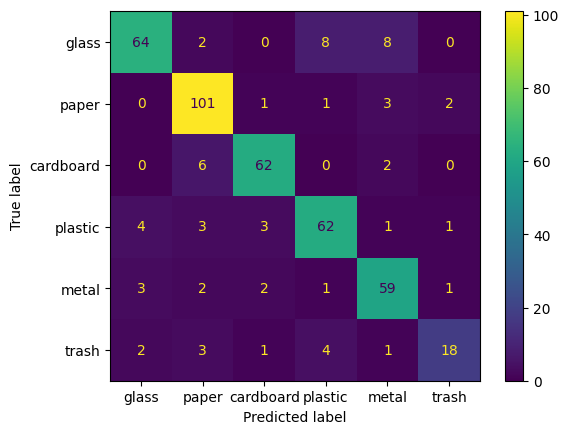

In [21]:
print("Confusion matrix:")
cm = confusion_matrix(test_data['labels'], test_data['preds'])
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes.values())
fig = disp.plot()
fig.figure_.savefig(os.path.join(FIGURES_PATH, "pytorch_pretrained_confusion_matrix_default.png"))
plt.show()

### Observations

* Even pretrained model struggles to find `trash` images

## Tune model

For tuning, let us apply these techniques:

* Add classes weights (since model is not able to distunguish `trash`)
* Add early stop for training
* Since it is pretrained model, it is worth trying to train different layers
  * Find best learning rate and `weight_decay` for each of the layer

### Add classes weights

In [22]:
class_counts = df_train["class"].value_counts().sort_index()
print(class_counts)

num_classes = class_counts.shape[0]

alpha = 0.5
class_weights = (1.0 / class_counts) ** alpha
# normalize, so that average weight is ~1
class_weights = class_weights / class_weights.mean()

print("class_weights:\n", class_weights)

# cast to tensor
class_weights_tensor = torch.tensor(class_weights.values, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

class
1    354
2    403
3    287
4    347
5    286
6     91
Name: count, dtype: int64
class_weights:
 class
1    0.840011
2    0.787289
3    0.932923
4    0.848441
5    0.934552
6    1.656784
Name: count, dtype: float64


### Add scheduler

In [23]:
def train_eval_model(
    model: nn.Module,
    num_epochs: int,
    best_model_path: str,
    optimizer,
    criterion,
) -> pd.DataFrame:
    rows = []
    best_val_acc = 0.0
    best_model_state = None

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=0.5,
        patience=5,
    )

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for _, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_acc": val_acc,
            }
            torch.save(best_model_state, best_model_path)
            print(f"  >> New best model! Val Acc = {val_acc:.4f}")

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}')
        scheduler.step(val_loss)

        rows.append((epoch, train_loss, train_acc, val_loss, val_acc))
        
    return pd.DataFrame(rows, columns=['epoch', 'train_loss', 'train_acc', 'val_loss', 'val_acc'])

### Train different layers separately

In [24]:
def run_experiment(lr, weight_decay, model, model_parameters, criterion, num_epochs=10):

    optimizer = torch.optim.Adam(
        model_parameters,
        lr=lr,
        weight_decay=weight_decay,
    )

    df_hist = train_eval_model(
        model=model,
        num_epochs=num_epochs,
        best_model_path=os.path.join(PROCESSED_DATA, f"best_resnet_lr{lr}_wd{weight_decay}.pt"),
        optimizer=optimizer,
        criterion=criterion,
    )

    best_val_acc = df_hist["val_acc"].max()
    return best_val_acc, df_hist

In [25]:
results = []
model = GarbageClassificationPretrained(num_classes=6)
model.to(device)

# freeze all the layers except 'fc'
for param in model.network.parameters():
    param.requires_grad = False

for param in model.network.fc.parameters():
    param.requires_grad = True

for lr in [1e-4, 3e-4, 1e-3]:
    for wd in [0.0, 1e-5, 1e-4]:
        print(f"Running lr={lr}, weight_decay={wd}")
        best_val_acc, hist = run_experiment(lr, wd, model, model.network.fc.parameters(), criterion)
        results.append((lr, wd, best_val_acc))

for lr, wd, acc in results:
    print(f"lr={lr}, wd={wd} -> best_val_acc={acc:.4f}")

/Users/vadim.sokoltsov/learning/bin-it-right/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vadim.sokoltsov/learning/bin-it-right/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Running lr=0.0001, weight_decay=0.0
  >> New best model! Val Acc = 0.5091
Epoch 1/10
  Train Loss: 1.6916, Train Acc: 0.3512
  Validation Loss: 1.5507, Validation Acc: 0.5091
  >> New best model! Val Acc = 0.6585
Epoch 2/10
  Train Loss: 1.4611, Train Acc: 0.6024
  Validation Loss: 1.3570, Validation Acc: 0.6585
  >> New best model! Val Acc = 0.7226
Epoch 3/10
  Train Loss: 1.2916, Train Acc: 0.6940
  Validation Loss: 1.2136, Validation Acc: 0.7226
  >> New best model! Val Acc = 0.7561
Epoch 4/10
  Train Loss: 1.1639, Train Acc: 0.7393
  Validation Loss: 1.1063, Validation Acc: 0.7561
  >> New best model! Val Acc = 0.7805
Epoch 5/10
  Train Loss: 1.0660, Train Acc: 0.7557
  Validation Loss: 1.0241, Validation Acc: 0.7805
Epoch 6/10
  Train Loss: 0.9891, Train Acc: 0.7658
  Validation Loss: 0.9595, Validation Acc: 0.7805
  >> New best model! Val Acc = 0.7835
Epoch 7/10
  Train Loss: 0.9271, Train Acc: 0.7749
  Validation Loss: 0.9075, Validation Acc: 0.7835
  >> New best model! Val Acc 

In [26]:
pretrained_model = GarbageClassificationPretrained(num_classes=6).to(device)

# freeze all the layers except 'fc'
for param in pretrained_model.network.parameters():
    param.requires_grad = False

for param in pretrained_model.network.fc.parameters():
    param.requires_grad = True

df_train_val_1 = train_eval_model(
        model=pretrained_model,
        num_epochs=60,
        best_model_path=best_model_pretrain_path,
        optimizer= torch.optim.Adam(
            pretrained_model.network.fc.parameters(),
            lr=0.001,
            weight_decay=0.0001,
        ),
        criterion=criterion,
    )

  >> New best model! Val Acc = 0.7530
Epoch 1/60
  Train Loss: 1.2849, Train Acc: 0.5396
  Validation Loss: 0.8388, Validation Acc: 0.7530
  >> New best model! Val Acc = 0.7957
Epoch 2/60
  Train Loss: 0.7662, Train Acc: 0.7562
  Validation Loss: 0.6831, Validation Acc: 0.7957
  >> New best model! Val Acc = 0.8171
Epoch 3/60
  Train Loss: 0.6298, Train Acc: 0.8077
  Validation Loss: 0.6196, Validation Acc: 0.8171
  >> New best model! Val Acc = 0.8232
Epoch 4/60
  Train Loss: 0.5537, Train Acc: 0.8224
  Validation Loss: 0.5858, Validation Acc: 0.8232
Epoch 5/60
  Train Loss: 0.5017, Train Acc: 0.8360
  Validation Loss: 0.5646, Validation Acc: 0.8201
Epoch 6/60
  Train Loss: 0.4623, Train Acc: 0.8456
  Validation Loss: 0.5498, Validation Acc: 0.8232
Epoch 7/60
  Train Loss: 0.4303, Train Acc: 0.8580
  Validation Loss: 0.5389, Validation Acc: 0.8232
  >> New best model! Val Acc = 0.8323
Epoch 8/60
  Train Loss: 0.4034, Train Acc: 0.8688
  Validation Loss: 0.5308, Validation Acc: 0.8323
  

In [27]:
result_ = []
for name, param in model.network.named_parameters():
    param.requires_grad = True

for lr in [1e-4, 3e-4, 1e-3, 1e-2]:
    for wd in [0.0, 1e-5, 1e-4, 1e-3]:
        print(f"Running lr={lr}, weight_decay={wd}")
        best_val_acc, hist = run_experiment(lr, wd, model, model.parameters(), criterion)
        result_.append((lr, wd, best_val_acc))

for lr, wd, acc in result_:
    print(f"lr={lr}, wd={wd} -> best_val_acc={acc:.4f}")

Running lr=0.0001, weight_decay=0.0
  >> New best model! Val Acc = 0.8933
Epoch 1/10
  Train Loss: 0.3925, Train Acc: 0.8756
  Validation Loss: 0.4730, Validation Acc: 0.8933
  >> New best model! Val Acc = 0.8963
Epoch 2/10
  Train Loss: 0.1055, Train Acc: 0.9644
  Validation Loss: 0.5797, Validation Acc: 0.8963
  >> New best model! Val Acc = 0.9055
Epoch 3/10
  Train Loss: 0.0581, Train Acc: 0.9791
  Validation Loss: 0.7145, Validation Acc: 0.9055
Epoch 4/10
  Train Loss: 0.0182, Train Acc: 0.9932
  Validation Loss: 0.7659, Validation Acc: 0.9024
  >> New best model! Val Acc = 0.9207
Epoch 5/10
  Train Loss: 0.0095, Train Acc: 0.9960
  Validation Loss: 0.4708, Validation Acc: 0.9207
  >> New best model! Val Acc = 0.9238
Epoch 6/10
  Train Loss: 0.0052, Train Acc: 0.9977
  Validation Loss: 0.4958, Validation Acc: 0.9238
Epoch 7/10
  Train Loss: 0.0029, Train Acc: 0.9994
  Validation Loss: 0.4687, Validation Acc: 0.9238
Epoch 8/10
  Train Loss: 0.0003, Train Acc: 1.0000
  Validation Los

In [28]:
for name, param in pretrained_model.network.named_parameters():
    param.requires_grad = True


df_train_val_final = train_eval_model(
        model=pretrained_model,
        num_epochs=60,
        best_model_path=best_model_pretrain_path,
        optimizer= torch.optim.Adam(
            pretrained_model.parameters(),
            lr=0.0001,
            weight_decay=0.0001,
        ),
        criterion=criterion,
    )

  >> New best model! Val Acc = 0.8841
Epoch 1/60
  Train Loss: 0.3837, Train Acc: 0.8705
  Validation Loss: 0.4582, Validation Acc: 0.8841
  >> New best model! Val Acc = 0.8933
Epoch 2/60
  Train Loss: 0.0822, Train Acc: 0.9706
  Validation Loss: 0.5703, Validation Acc: 0.8933
  >> New best model! Val Acc = 0.9360
Epoch 3/60
  Train Loss: 0.0341, Train Acc: 0.9932
  Validation Loss: 0.4795, Validation Acc: 0.9360
  >> New best model! Val Acc = 0.9421
Epoch 4/60
  Train Loss: 0.0123, Train Acc: 0.9960
  Validation Loss: 0.4338, Validation Acc: 0.9421
  >> New best model! Val Acc = 0.9482
Epoch 5/60
  Train Loss: 0.0059, Train Acc: 0.9983
  Validation Loss: 0.3873, Validation Acc: 0.9482
  >> New best model! Val Acc = 0.9543
Epoch 6/60
  Train Loss: 0.0011, Train Acc: 0.9994
  Validation Loss: 0.3775, Validation Acc: 0.9543
Epoch 7/60
  Train Loss: 0.0003, Train Acc: 1.0000
  Validation Loss: 0.3814, Validation Acc: 0.9543
Epoch 8/60
  Train Loss: 0.0002, Train Acc: 1.0000
  Validation L

### Visualization

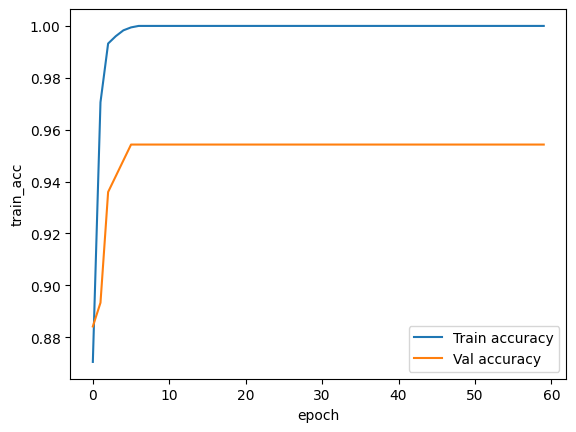

In [29]:
sns.lineplot(data=df_train_val_final, x='epoch', y='train_acc', label='Train accuracy')
sns.lineplot(data=df_train_val_final, x='epoch', y='val_acc', label='Val accuracy')
plt.savefig(
    os.path.join(FIGURES_PATH, "pytorch_pretrained_accuracy_tuned.png")
)
plt.show()

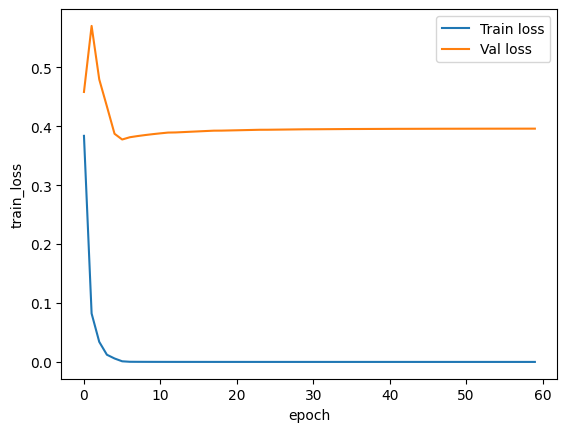

In [30]:
sns.lineplot(data=df_train_val_final, x='epoch', y='train_loss', label='Train loss')
sns.lineplot(data=df_train_val_final, x='epoch', y='val_loss', label='Val loss')
plt.savefig(
    os.path.join(FIGURES_PATH, "pytorch_pretrained_loss_tuned.png")
)
plt.show()

## Test model

In [31]:
model = GarbageClassificationPretrained(num_classes=6)
checkpoint = torch.load(
    best_model_pretrain_path,
    map_location=device
)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()

test_data = test_model(model=model)

/Users/vadim.sokoltsov/learning/bin-it-right/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vadim.sokoltsov/learning/bin-it-right/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
y_true = test_data["labels"]
y_pred = test_data["preds"]

metrics = {
    "accuracy": accuracy_score(y_true, y_pred),
    "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
    "macro_f1": f1_score(y_true, y_pred, average="macro"),
    "weighted_f1": f1_score(y_true, y_pred, average="weighted"),
    "micro_f1": f1_score(y_true, y_pred, average="micro"),
    "macro_precision": precision_score(y_true, y_pred, average="macro", zero_division=0),
    "macro_recall": recall_score(y_true, y_pred, average="macro", zero_division=0),
    "mcc": matthews_corrcoef(y_true, y_pred),
}

for k, v in metrics.items():
    print(f"{k:>18}: {v:.4f}")

          accuracy: 0.9327
 balanced_accuracy: 0.9300
          macro_f1: 0.9338
       weighted_f1: 0.9328
          micro_f1: 0.9327
   macro_precision: 0.9387
      macro_recall: 0.9300
               mcc: 0.9176


In [33]:
print("Classification report:")
print(classification_report(test_data['labels'], test_data['preds'], digits=3))

Classification report:
              precision    recall  f1-score   support

           0      0.927     0.927     0.927        82
           1      0.920     0.963     0.941       108
           2      0.984     0.900     0.940        70
           3      0.896     0.932     0.914        74
           4      0.940     0.926     0.933        68
           5      0.964     0.931     0.947        29

    accuracy                          0.933       431
   macro avg      0.939     0.930     0.934       431
weighted avg      0.934     0.933     0.933       431



Confusion matrix:
[[ 76   0   0   3   3   0]
 [  0 104   1   1   1   1]
 [  0   7  63   0   0   0]
 [  4   1   0  69   0   0]
 [  2   0   0   3  63   0]
 [  0   1   0   1   0  27]]


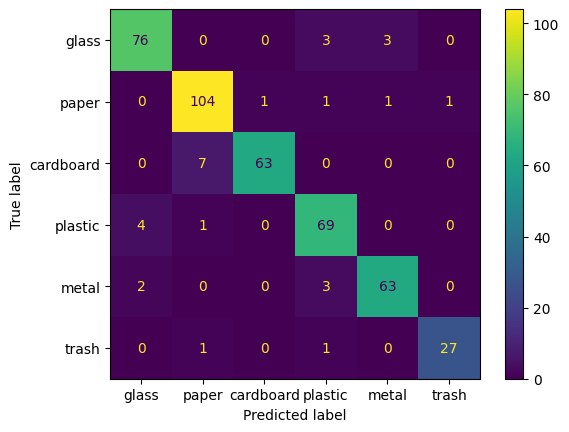

In [34]:
print("Confusion matrix:")
cm = confusion_matrix(test_data['labels'], test_data['preds'])
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes.values())
fig = disp.plot()
fig.figure_.savefig(os.path.join(FIGURES_PATH, "pytorch_pretrained_confusion_matrix_tuned.png"))
plt.show()